In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, concatenate, GlobalAveragePooling2D, Dense
from keras.applications import DenseNet121, ResNet50
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback


input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

# Instantiate DenseNet121 and exclude the top (classification) layer
densenet_base = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze DenseNet layers
for layer in densenet_base.layers:
    layer.trainable = False

# Extract features using DenseNet
densenet_features = densenet_base(input_tensor)

# Use some layers of ResNet
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze ResNet layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_features = resnet_base(input_tensor)

# Concatenate features from both networks
merged_features = concatenate([densenet_features, resnet_features])

# Add classification layers
x = GlobalAveragePooling2D()(merged_features)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

# Create the hybrid model
hybrid_model = Model(inputs=input_tensor, outputs=output)

# Compile the model
hybrid_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have train_data and validation_data directories with subdirectories for each class
train_data_dir = 'D:/Dataset1/train'
validation_data_dir = 'D:/Dataset1/val'
batch_size = 32

# Use data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Use rescaling for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for confusion matrix and predictions
)

# Train the model
num_epochs = 30

history = hybrid_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)



c:\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Found 8640 images belonging to 6 classes.
Found 721 images belonging to 6 classes.
Epoch 1/30
270/270 [==============================] - 1210s 4s/step - loss: 0.6910 - accuracy: 0.7707 - val_loss: 0.2954 - val_accuracy: 0.8864
Epoch 2/30
270/270 [==============================] - 1185s 4s/step - loss: 0.3467 - accuracy: 0.8803 - val_loss: 0.2015 - val_accuracy: 0.9276
Epoch 3/30
270/270 [==============================] - 1180s 4s/step - loss: 0.2947 - accuracy: 0.8987 - val_loss: 0.2997 - val_accuracy: 0.8935
Epoch 4/30
270/270 [==============================] - 1183s 4s/step - loss: 0.2400 - accuracy: 0.9157 - val_loss: 0.2799 - val_accuracy: 0.9148
Epoch 5/30
270/270 [==============================] - 1198s 4s/step - loss: 0.2459 - accuracy: 0.9130 - val_loss: 0.2470 - val_accuracy: 0.9233
Epoch 6/30
270/270 [==============================] - 1200s 4s/step - loss: 0.2526 - accuracy: 0.9117 - val_loss: 0.1688 - val_accuracy: 0.9389
Epoch 7/30
270/270 [==============================] -

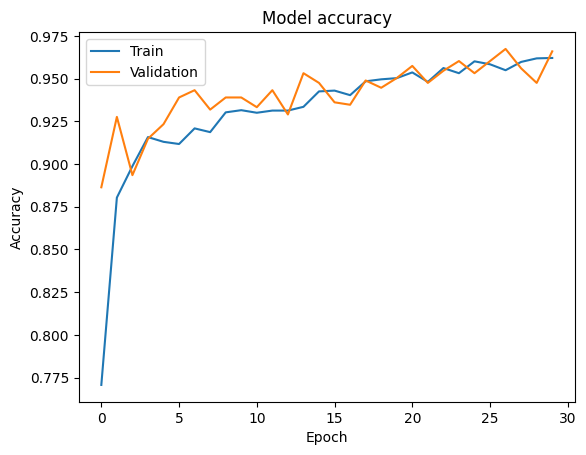

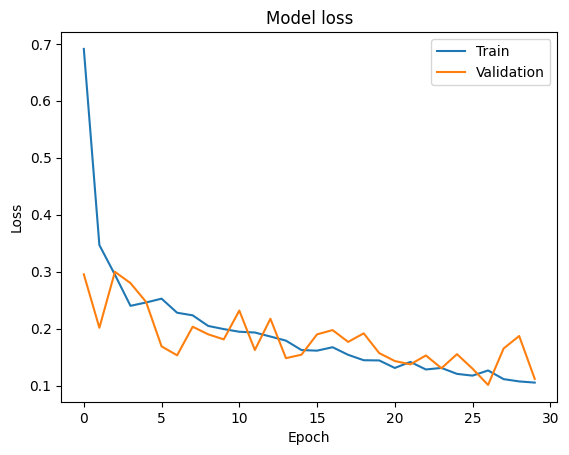

23/23 [==============================] - 87s 4s/step
                  precision    recall  f1-score   support

          Aphids       0.96      0.97      0.96       120
       Army_worm       0.98      1.00      0.99       120
Bacterial_Blight       0.92      0.96      0.94       120
         Healthy       0.96      1.00      0.98       120
  Powdery_Mildew       1.00      0.97      0.98       120
     Target_spot       0.96      0.89      0.93       121

        accuracy                           0.96       721
       macro avg       0.96      0.96      0.96       721
    weighted avg       0.96      0.96      0.96       721



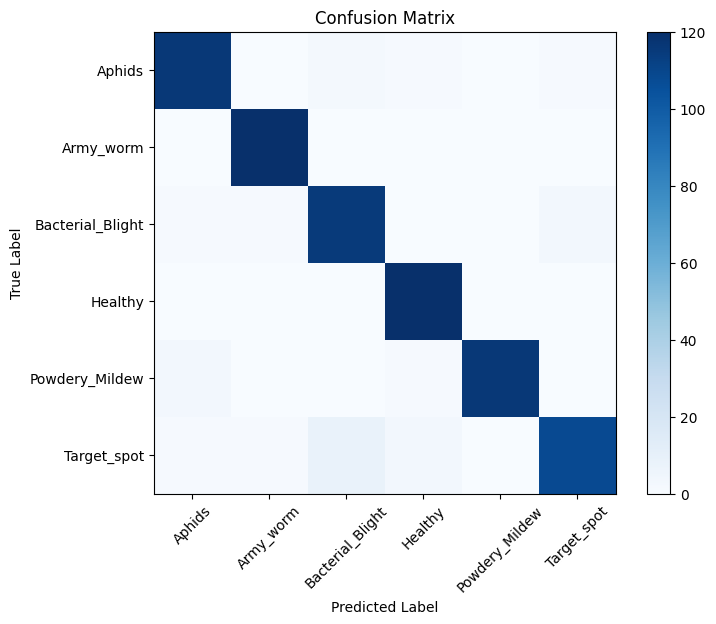

In [4]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Generate predictions
y_pred = hybrid_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes

# Generate classification report
class_labels = list(validation_generator.class_indices.keys())
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [5]:
import random

# Select random 5 images
random_indices = random.sample(range(len(validation_generator)), 5)

# Get the filenames, true labels, and predicted labels for the randomly selected images
true_labels = []
predicted_labels = []

for i in random_indices:
    batch = validation_generator[i]
    images = batch[0]
    true_batch_labels = batch[1]
    true_labels.extend(np.argmax(true_batch_labels, axis=1))  # True labels
    pred_batch_labels = hybrid_model.predict(images)
    predicted_labels.extend(np.argmax(pred_batch_labels, axis=1))  # Predicted labels

# Map labels to class names
class_labels = {v: k for k, v in validation_generator.class_indices.items()}

# Display true labels and predicted labels for the randomly selected images
print("True Labels\tPredicted Labels")
print("-" * 30)
for true_label, predicted_label in zip(true_labels, predicted_labels):
    true_class = class_labels[true_label]
    predicted_class = class_labels[predicted_label]
    print(f"{true_class}\t\t{predicted_class}")


1/1 [==============================] - 4s 4s/step
True Labels	Predicted Labels
------------------------------
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Bacterial_Blight
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Bacterial_Blight
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Army_worm
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Target_spot
Target_spot		Aphids
Target_spot		Target_spot
Aphids		Aphids
Aphids		Aphids
Aphids		Aphids
Aphids		Aphids
Aphids		Aphids
Aphids		Aphi

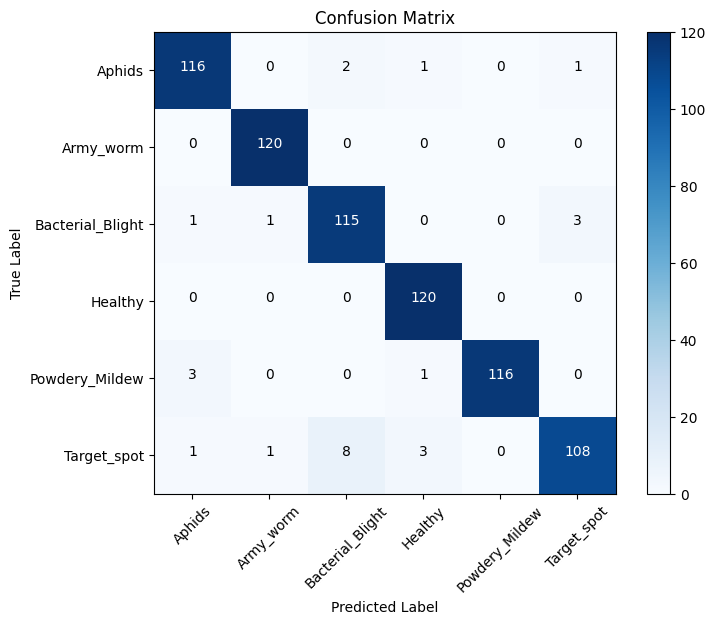

In [3]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Display values inside the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


1/1 [==============================] - 4s 4s/step


ValueError: num must be an integer with 1 <= num <= 5, not 6

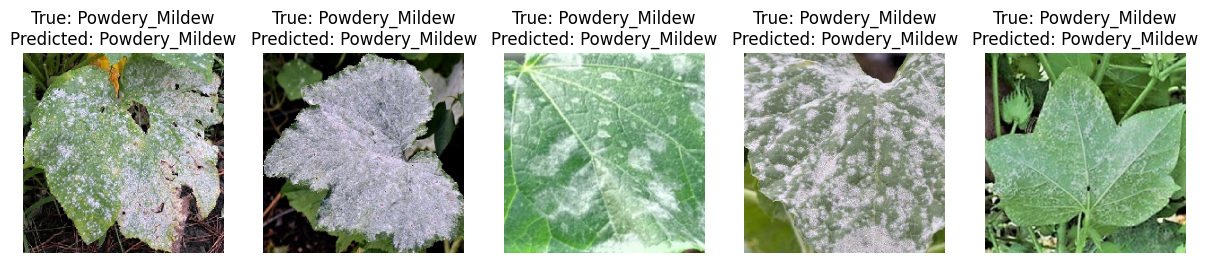

In [8]:
import random
import matplotlib.pyplot as plt

# Select random 5 images
random_indices = random.sample(range(len(validation_generator)), 5)

# Get the filenames, true labels, and predicted labels for the randomly selected images
true_labels = []
predicted_labels = []
images = []

for i in random_indices:
    batch = validation_generator[i]
    batch_images = batch[0]
    true_batch_labels = batch[1]
    images.extend(batch_images)
    true_labels.extend(np.argmax(true_batch_labels, axis=1))  # True labels
    pred_batch_labels = hybrid_model.predict(batch_images)
    predicted_labels.extend(np.argmax(pred_batch_labels, axis=1))  # Predicted labels

# Map labels to class names
class_labels = {v: k for k, v in validation_generator.class_indices.items()}

# Display images along with true and predicted labels
plt.figure(figsize=(15, 10))
for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels), 1):
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(f"True: {class_labels[true_label]}\nPredicted: {class_labels[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Get the final training and validation loss values
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

print("Final Training Loss:", final_training_loss)
print("Final Validation Loss:", final_validation_loss)


Final Training Loss: 0.1052677258849144
Final Validation Loss: 0.11179769784212112


In [10]:
# Get the final training and validation accuracy values
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.9620370268821716
Final Validation Accuracy: 0.9659090638160706
